# Problem Set 1

## Problem 4

In [2]:
import numpy as np
from scipy.stats import t

# Define parameters
theta = 35.5
sigma = 5.5
alpha = 0.05
M = 100000

rng = np.random.default_rng(0)
C = np.empty(M, dtype=int)

# Repeat experiment M times
for i in range(M):
    sample = []
    while True:
        x = rng.normal(theta, sigma)
        sample.append(x)
        
        # Stopping rule: observing value < 25
        if x <= 25:
            break
    
    N = len(sample)
    xbar = np.mean(sample)
    
    # Handle edge case of 1 observed sample
    if N == 1:
        crit = np.inf
    else:
        crit = t.ppf(1 - alpha/2, df=N-1)
    
    halfwidth = sigma * crit / np.sqrt(N)
    
    # Does the interval cover the true mean? Store 1 for Yes and 0 for No
    C[i] = int((xbar - halfwidth <= theta) and (theta <= xbar + halfwidth))

# Compute what fraction of intervals contains true mean value
p_hat = C.mean()

se_hat = np.sqrt(p_hat * (1 - p_hat) / M)

print("Estimate =", p_hat)
print("Difference =", p_hat - (1 - alpha))

Estimate = 0.97349
Difference = 0.02349000000000001


## Problem 5

In [3]:
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp

x = np.array([26.6, 38.5, 34.4, 34.0, 31.0, 23.6])
n = len(x)

thetas = np.linspace(20, 40, 701)  
logsigs = np.linspace(-1, 3, 801)
dtheta = thetas[1] - thetas[0]
dlogs = logsigs[1] - logsigs[0]

Theta, LogS = np.meshgrid(thetas, logsigs, indexing="xy")
Sigma = np.exp(LogS)

logpost = np.zeros_like(Theta)


for xi in x:
    z = (xi - Theta) / Sigma
    log_phi = norm.logpdf(z)
    log_prob_in_range = np.log(norm.cdf((39 - Theta) / Sigma) - norm.cdf((23 - Theta) / Sigma))
    logpost += log_phi - np.log(Sigma) - log_prob_in_range

prob_failure = norm.cdf((23 - Theta) / Sigma) + (1 - norm.cdf((39 - Theta) / Sigma))
logpost += 2 * np.log(prob_failure)

logZ = logsumexp(logpost.ravel()) + np.log(dtheta * dlogs)
post = np.exp(logpost - logZ)

print("Grid integral =", post.sum() * dtheta * dlogs)

Grid integral = 1.0000000000000007


In [4]:
import numpy as np
from scipy.stats import t

# Observed data
x = np.array([26.6, 38.5, 34.4, 34.0, 31.0, 23.6])
n = len(x)

marg_theta = post.sum(axis=0) * dlogs  
marg_theta = marg_theta / (marg_theta.sum() * dtheta) 

cdf = np.cumsum(marg_theta) * dtheta
theta_lo = np.interp(0.025, cdf, thetas)
theta_hi = np.interp(0.975, cdf, thetas)

print("Bayesian 95% credible interval for theta:", (theta_lo, theta_hi))

xbar = x.mean()
s = x.std(ddof=1)
tcrit = t.ppf(0.975, df=n-1)
usual_lo = xbar - tcrit * s / np.sqrt(n)
usual_hi = xbar + tcrit * s / np.sqrt(n)

print("Usual 95% t-interval for theta:", (usual_lo, usual_hi))

Bayesian 95% credible interval for theta: (np.float64(20.51839490750134), np.float64(39.57631745618241))
Usual 95% t-interval for theta: (np.float64(25.59826929004444), np.float64(37.10173070995556))


In [5]:
# Comparison
bayesian_width = theta_hi - theta_lo
usual_width = usual_hi - usual_lo

print(f"\n{'='*60}")
print("COMPARISON:")
print(f"{'='*60}")
print(f"Bayesian interval: ({theta_lo:.3f}, {theta_hi:.3f})")
print(f"Width: {bayesian_width:.3f}")
print(f"\nUsual interval: ({usual_lo:.3f}, {usual_hi:.3f})")
print(f"Width: {usual_width:.3f}")
print(f"\nDifference in widths: {bayesian_width - usual_width:.3f}")


COMPARISON:
Bayesian interval: (20.518, 39.576)
Width: 19.058

Usual interval: (25.598, 37.102)
Width: 11.503

Difference in widths: 7.554


The Bayesian interval is larger by 7.554 units. The Bayesian analysis accounts for the 2 failed measurements, which increases uncertainty about theta. The usual analysis ignores the failures entirely and only uses the 6 successful observations, leading to an artificially narrow / overconfident interval.

## Problem 6

In [6]:
x_obs = np.array([26.6, 38.5, 34.4, 34.0, 31.0, 23.6])
m_fail = 2

thetas = np.linspace(15, 50, 701)
logsigs = np.linspace(-1, 3, 801)
dtheta = thetas[1] - thetas[0]
dlogs = logsigs[1] - logsigs[0]

Theta, LogS = np.meshgrid(thetas, logsigs, indexing="xy")
Sigma = np.exp(LogS)

loglike = np.zeros_like(Theta)

for xi in x_obs:
    z = (xi - Theta) / Sigma
    loglike += (-np.log(Sigma) + norm.logpdf(z))

a = (23 - Theta) / Sigma
b = (39 - Theta) / Sigma
p_fail = norm.cdf(a) + (1 - norm.cdf(b))
loglike += m_fail * np.log(p_fail + 1e-300)  

logpost = loglike

logZ = logsumexp(logpost.ravel()) + np.log(dtheta * dlogs)
post = np.exp(logpost - logZ)

print("Normalization check:", post.sum() * dtheta * dlogs)


Normalization check: 0.9999999999999994


In [7]:
marg_theta = post.sum(axis=0) * dlogs 
marg_theta = marg_theta / (marg_theta.sum() * dtheta) 

cdf = np.cumsum(marg_theta) * dtheta
theta_lo = np.interp(0.025, cdf, thetas)
theta_hi = np.interp(0.975, cdf, thetas)

print("Bayesian 95% credible interval for theta:", (theta_lo, theta_hi))

xbar = x_obs.mean()
s = x_obs.std(ddof=1)
tcrit = t.ppf(0.975, df=len(x_obs)-1)
usual_lo = xbar - tcrit * s / np.sqrt(len(x_obs))
usual_hi = xbar + tcrit * s / np.sqrt(len(x_obs))

print("Usual (non-truncated) 95% t-interval for theta:", (usual_lo, usual_hi))

# Comparison
bayesian_width = theta_hi - theta_lo
usual_width = usual_hi - usual_lo

print(f"\nInterval widths:")
print(f"  Bayesian: {bayesian_width:.3f}")
print(f"  Usual: {usual_width:.3f}")
print(f"  Difference: {bayesian_width - usual_width:.3f}")

Bayesian 95% credible interval for theta: (np.float64(22.488091258700134), np.float64(40.35055934266726))
Usual (non-truncated) 95% t-interval for theta: (np.float64(25.59826929004444), np.float64(37.10173070995556))

Interval widths:
  Bayesian: 17.862
  Usual: 11.503
  Difference: 6.359


The Bayesian interval is larger by 6.359 units.

## Problem 7

/tmp/ipykernel_2725518/2937397517.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Z = np.trapz(unnorm, theta)
/tmp/ipykernel_2725518/2937397517.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"Normalization check (should be approx 1): {np.trapz(dens, theta):.10f}")


Normalization check (should be approx 1): 1.0000000000


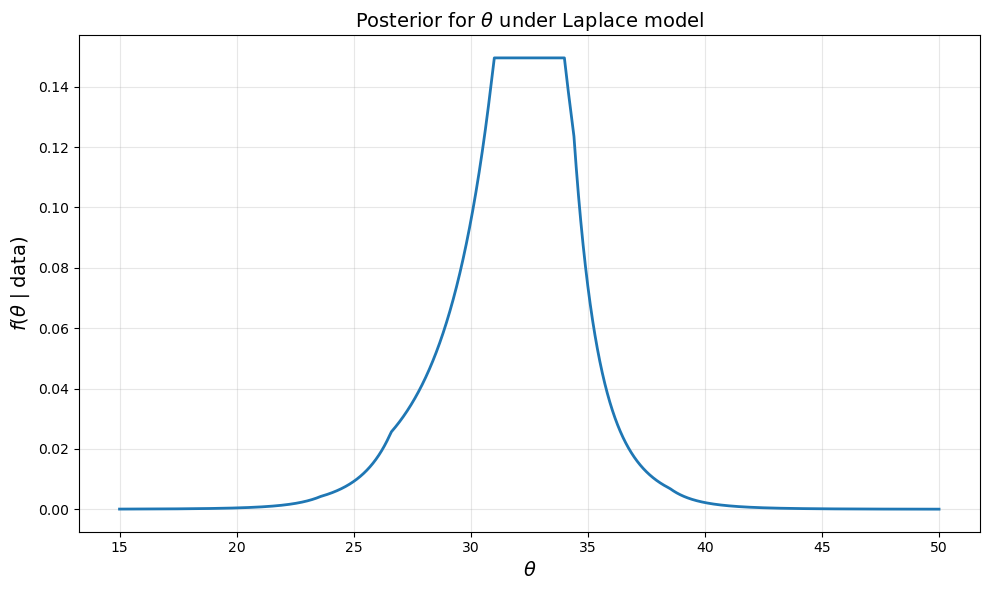

In [9]:
# Part b
import matplotlib.pyplot as plt

x = np.array([26.6, 38.5, 34.4, 34.0, 31.0, 23.6])
n = len(x)

theta = np.linspace(15, 50, 20001)

M = np.sum(np.abs(x[:, None] - theta[None, :]), axis=0)

unnorm = M**(-n)

Z = np.trapz(unnorm, theta)  
dens = unnorm / Z  

print(f"Normalization check (should be approx 1): {np.trapz(dens, theta):.10f}")

# Plot the posterior
plt.figure(figsize=(10, 6))
plt.plot(theta, dens, linewidth=2)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$f(\theta \mid \text{data})$', fontsize=14)
plt.title(r'Posterior for $\theta$ under Laplace model', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The posterior density is seemingly symmetric around θ = 32 approximately, which corresponds to the sample median of the data. The Laplace model flat-topped peak arises due to the absolute deviation loss function, with most of the probability mass concentrated between approximately 28 and 36.

In [10]:
# Part c
from scipy.stats import t

# Build CDF from the discretized posterior
cdf = np.zeros_like(theta)
cdf[1:] = np.cumsum(0.5*(dens[1:]+dens[:-1])*(theta[1:]-theta[:-1]))

# Quantiles for 95% credible interval
theta_lo = np.interp(0.025, cdf, theta)
theta_hi = np.interp(0.975, cdf, theta)

print("Laplace 95% credible interval for theta:", (theta_lo, theta_hi))

# Compare: normal based method from class
xbar = x.mean()
s = x.std(ddof=1)
tcrit = t.ppf(0.975, df=n-1)
normal_lo = xbar - tcrit * s / np.sqrt(n)
normal_hi = xbar + tcrit * s / np.sqrt(n)

print("Normal-based 95% t-interval for theta:", (normal_lo, normal_hi))

# Comparison
laplace_width = theta_hi - theta_lo
normal_width = normal_hi - normal_lo

print(f"\nInterval widths:")
print(f"  Laplace: {laplace_width:.3f}")
print(f"  Normal: {normal_width:.3f}")
print(f"  Difference: {laplace_width - normal_width:.3f}")

Laplace 95% credible interval for theta: (np.float64(25.81116554713452), np.float64(37.08871846896364))
Normal-based 95% t-interval for theta: (np.float64(25.59826929004444), np.float64(37.10173070995556))

Interval widths:
  Laplace: 11.278
  Normal: 11.503
  Difference: -0.226


Very minimal difference due to no extreme outliers in the data.

In [13]:
# Part d
from scipy.stats import t

x_outlier = np.array([26.6, 38.5, 34.4, 34.0, 31.0, 23.6, 120.0])
n_outlier = len(x_outlier)

theta = np.linspace(15, 150, 20001) 

M = np.sum(np.abs(x_outlier[:, None] - theta[None, :]), axis=0)
unnorm = M**(-n_outlier)

Z = np.trapz(unnorm, theta)
dens = unnorm / Z

print(f"Normalization check: {np.trapz(dens, theta):.10f}")

cdf = np.zeros_like(theta)
cdf[1:] = np.cumsum(0.5*(dens[1:]+dens[:-1])*(theta[1:]-theta[:-1]))

theta_lo_laplace = np.interp(0.025, cdf, theta)
theta_hi_laplace = np.interp(0.975, cdf, theta)

print(f"Laplace 95% credible interval: ({theta_lo_laplace:.3f}, {theta_hi_laplace:.3f})")

xbar_outlier = x_outlier.mean()
s_outlier = x_outlier.std(ddof=1)
tcrit_outlier = t.ppf(0.975, df=n_outlier-1)
normal_lo_outlier = xbar_outlier - tcrit_outlier * s_outlier / np.sqrt(n_outlier)
normal_hi_outlier = xbar_outlier + tcrit_outlier * s_outlier / np.sqrt(n_outlier)

print(f"Normal-based 95% t-interval: ({normal_lo_outlier:.3f}, {normal_hi_outlier:.3f})")

# Comparison
laplace_width_outlier = theta_hi_laplace - theta_lo_laplace
normal_width_outlier = normal_hi_outlier - normal_lo_outlier

print(f"\nInterval widths:")
print(f"Laplace: {laplace_width_outlier:.3f}")
print(f"Normal: {normal_width_outlier:.3f}")
print(f"Difference: {normal_width_outlier - laplace_width_outlier:.3f}")


Normalization check: 1.0000000000
Laplace 95% credible interval: (21.828, 47.715)
Normal-based 95% t-interval: (12.682, 75.346)

Interval widths:
Laplace: 25.887
Normal: 62.664
Difference: 36.776


/tmp/ipykernel_2725518/2127649559.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Z = np.trapz(unnorm, theta)
/tmp/ipykernel_2725518/2127649559.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"Normalization check: {np.trapz(dens, theta):.10f}")


The outlier x7 = 120 has a much larger effect on the Normal-based interval than on the Laplace interval. The Laplace model is robust to outliers because it uses absolute deviations, while the Normal model uses squared deviations which heavily penalize extreme values.